In [5]:
from inspect import isdatadescriptor
import requests
import xml.dom.minidom as m
import xml.etree.ElementTree as ET
import json

In [6]:
def get_pmids(condition, year):
    pmids = []
    r = requests.get(
        f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term={condition}+AND+{year}[pdat]&retmode=xml&retmax=1000"
    )
    doc = m.parseString(r.text)
    ids = doc.getElementsByTagName("Id")
    for i in ids:
        pmids.append(i.childNodes[0].wholeText)
        #print(i.childNodes[0].wholeText)
    return pmids

alzh_pmids_list = get_pmids("Alzheimers", 2022)
cancer_pmids_list = get_pmids("Cancer", 2022)

alzh_pmids = ",".join(alzh_pmids_list)
cancer_pmids = ",".join(cancer_pmids_list)

print(alzh_pmids, "\n", cancer_pmids)

36315115,36314730,36314503,36314232,36314212,36314211,36314210,36314209,36314208,36314207,36314206,36314205,36314204,36314203,36314202,36314201,36314200,36314199,36314055,36313968,36313967,36313229,36312018,36311713,36311031,36309938,36309725,36309183,36309087,36308033,36306920,36306735,36306540,36306459,36306458,36305541,36305459,36305148,36305125,36304998,36304823,36304723,36304124,36303870,36303331,36303296,36302665,36302659,36302488,36302464,36301043,36299613,36299608,36298279,36297317,36297313,36296980,36296969,36296692,36296686,36296677,36296574,36296397,36295605,36295535,36294010,36293946,36293666,36293539,36293528,36293516,36293327,36293221,36293147,36293049,36292947,36292945,36292933,36292931,36292674,36292623,36292114,36291714,36291679,36291666,36291661,36291618,36291595,36291553,36291536,36291224,36291125,36291068,36291020,36291017,36290612,36289878,36289859,36289565,36289390,36289355,36288997,36288945,36288546,36288285,36287605,36287554,36286505,36286438,36286188,36285785,3

In [7]:
def get_info(pmids):
    metadata_dict_w_pmid = {}
    url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    r = requests.post(
        url, data = {
                        "id": pmids,
                        "db": "PubMed",
                        "retmode": "xml"
                    }
    )

    doc = m.parseString(r.text)
    #print(pmid_current_decoded)
    
    articles = doc.getElementsByTagName("MedlineCitation")
    #print("articles.length", articles.length)
    counter = 0
    for i in articles:
        metadata_dict = {}

        pmid_current_tag = doc.getElementsByTagName("PMID")
        pmid_current = ET.fromstring(pmid_current_tag[counter].toxml())
        pmid_current_decoded = ET.tostring(pmid_current, method = "text").decode()
        #print(pmid_current_decoded)
        
        all_title = ""
        all_abstract = ""
        titles = i.getElementsByTagName("ArticleTitle")
        abstracts = i.getElementsByTagName("AbstractText")
        try:
            title.length >= 1
        except:
            for j in range(titles.length):
                title_forDecode = ET.fromstring(titles[j].toxml())
                title = ET.tostring(title_forDecode, method = "text").decode()
                all_title += title + " "   
        else:
            all_title = "No title"
            

        try:
            abstracts.length >= 1
        except:
            all_abstract = "No Abstract"
        else:
            for k in range(abstracts.length):
                abstract_forDecode = ET.fromstring(abstracts[k].toxml())
                abstract = ET.tostring(abstract_forDecode, method = "text").decode()
                all_abstract += abstract + " "

        if pmid_current_decoded in alzh_pmids:
            query = "Alzheimers"
        else:
            query = "Cancer"

        metadata_dict["ArticleTitle"] = all_title
        metadata_dict["AbstractText"] = all_abstract
        metadata_dict["query"] = query
        metadata_dict_w_pmid[pmid_current_decoded] = metadata_dict
        counter += 1

    #print("counter", counter)
    return metadata_dict_w_pmid

alzh_metadata_dict = get_info(alzh_pmids)
cancer_metadata_dict = get_info(cancer_pmids)


In [9]:
alzh_dump = json.dumps(alzh_metadata_dict, indent=4)
cancer_dump = json.dumps(cancer_metadata_dict, indent=4)
 
with open("alzheimer_metadata.json", "w") as outfile:
    outfile.write(alzh_dump)
with open("cancer_metadata.json", "w") as outfile:
    outfile.write(cancer_dump)

In [10]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

print(intersection(alzh_pmids_list,cancer_pmids_list))

['36314209']


In [1]:
from transformers import AutoTokenizer, AutoModel

# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
model = AutoModel.from_pretrained('allenai/specter')

In [31]:
import tqdm

# we can use a persistent dictionary (via shelve) so we can stop and restart if needed
# alternatively, do the same but with embeddings starting as an empty dictionary

def specter(papers):
    embeddings = {}
    for pmid, paper in tqdm.tqdm(papers.items()):
        data = [paper["ArticleTitle"] + tokenizer.sep_token + paper["AbstractText"]]
        inputs = tokenizer(
            data, padding=True, truncation=True, return_tensors="pt", max_length=512
        )
        result = model(**inputs)
        # take the first token in the batch as the embedding
        embeddings[pmid] = result.last_hidden_state[:, 0, :].detach().numpy()[0]

    # turn our dictionary into a list
    embeddings = [embeddings[pmid] for pmid in papers.keys()]
    return embeddings

In [32]:
alzh_specter = specter(alzh_metadata_dict)

100%|██████████| 1000/1000 [02:46<00:00,  5.99it/s]


In [37]:
cancer_specter = specter(cancer_metadata_dict)

100%|██████████| 1000/1000 [02:38<00:00,  6.31it/s]


In [27]:
from sklearn import decomposition
import pandas as pd

def pca(embeddings, papers):
    pca = decomposition.PCA(n_components=3)
    embeddings_pca = pd.DataFrame(
        pca.fit_transform(embeddings),
        columns=['PC0', 'PC1', 'PC2']
    )
    embeddings_pca["query"] = [paper["query"] for paper in papers.values()]
    return embeddings_pca

In [38]:
cancer_pca = pca(cancer_specter, cancer_metadata_dict)

In [39]:
alzh_pca = pca(alzh_specter, alzh_metadata_dict)

In [43]:
print(alzh_pca)

          PC0       PC1       PC2       query
0   -3.745878  0.058747 -0.734064  Alzheimers
1   -1.435304 -4.179104 -0.132779  Alzheimers
2   -5.494734  0.364736  2.889990  Alzheimers
3   -3.359788 -1.857247  0.420889  Alzheimers
4   -7.071063  2.027740  3.288957      Cancer
..        ...       ...       ...         ...
995  2.563257 -1.376240  2.299065  Alzheimers
996  5.104806 -1.394370  3.517081  Alzheimers
997  3.513052 -1.557928 -1.176074  Alzheimers
998 -2.611474 -2.526443  2.100104  Alzheimers
999 -4.885276 -0.425316 -2.675942  Alzheimers

[1000 rows x 4 columns]


In [59]:
frames = [alzh_pca, cancer_pca]
result = pd.concat(frames)
print(result)

          PC0       PC1       PC2       query
0   -3.745878  0.058747 -0.734064  Alzheimers
1   -1.435304 -4.179104 -0.132779  Alzheimers
2   -5.494734  0.364736  2.889990  Alzheimers
3   -3.359788 -1.857247  0.420889  Alzheimers
4   -7.071063  2.027740  3.288957      Cancer
..        ...       ...       ...         ...
995  7.038965  0.785861 -3.278932      Cancer
996  2.782970  6.328247 -1.023132      Cancer
997 -1.745330 -2.630009 -6.417033      Cancer
998 -3.237673 -4.450319 -6.521972      Cancer
999 -2.804029 -4.290997 -0.522862      Cancer

[2000 rows x 4 columns]


<AxesSubplot: xlabel='PC0', ylabel='PC1'>

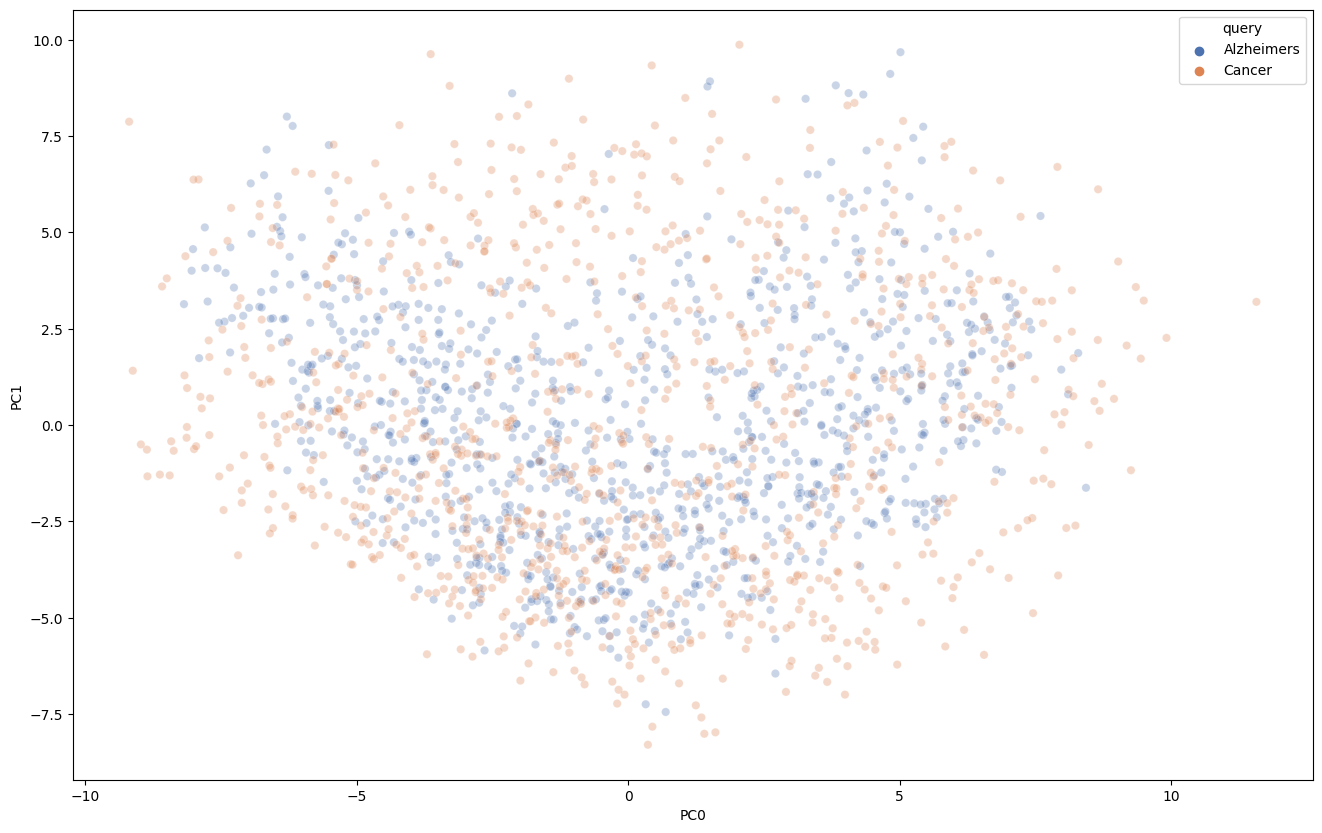

In [77]:
import seaborn as sns

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="PC0", y="PC1",
    hue="query",
    palette=sns.color_palette("deep", 2),
    data=result,
    legend="full",
    alpha=0.3
)

<AxesSubplot: xlabel='PC1', ylabel='PC2'>

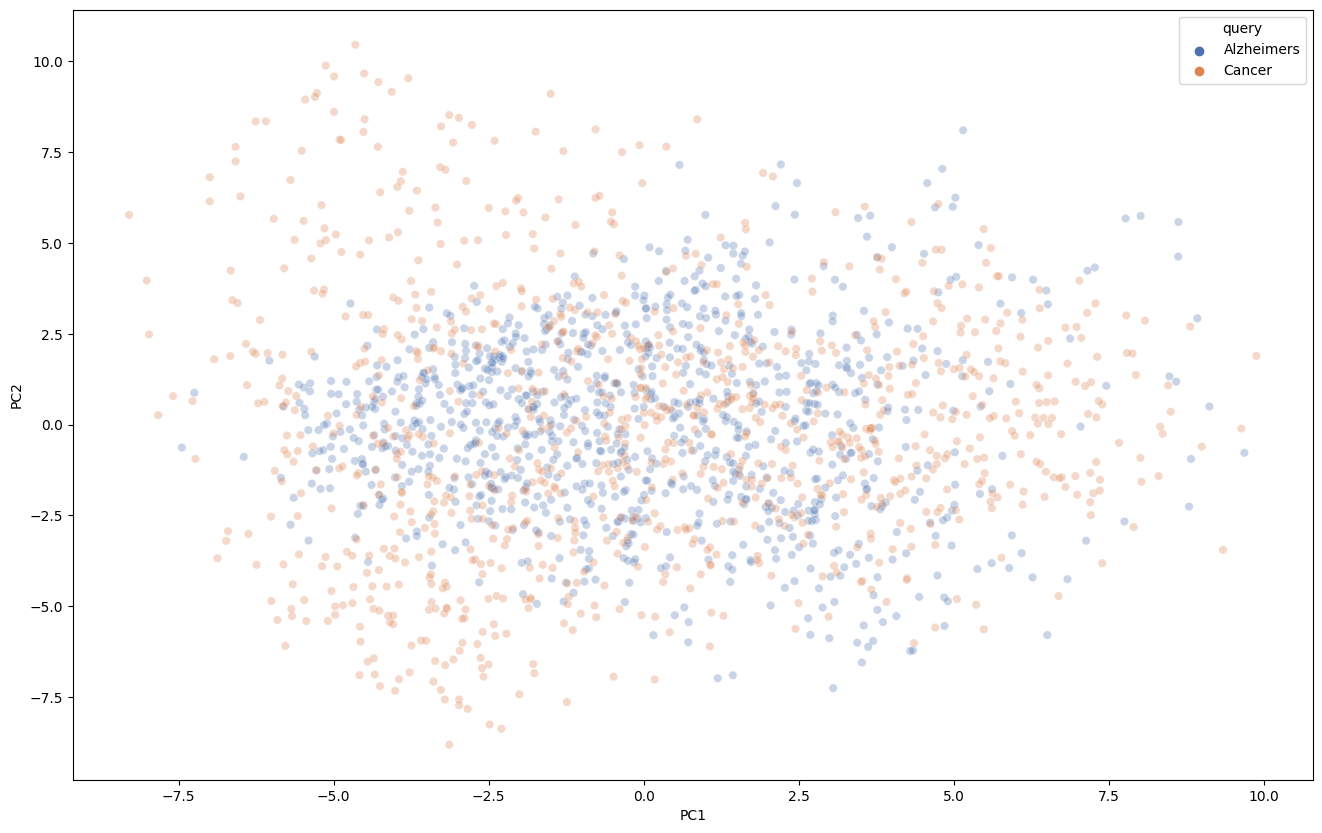

In [75]:
import seaborn as sns

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="PC1", y="PC2",
    hue="query",
    palette=sns.color_palette("deep", 2),
    data=result,
    legend="full",
    alpha=0.3
)

<AxesSubplot: xlabel='PC0', ylabel='PC2'>

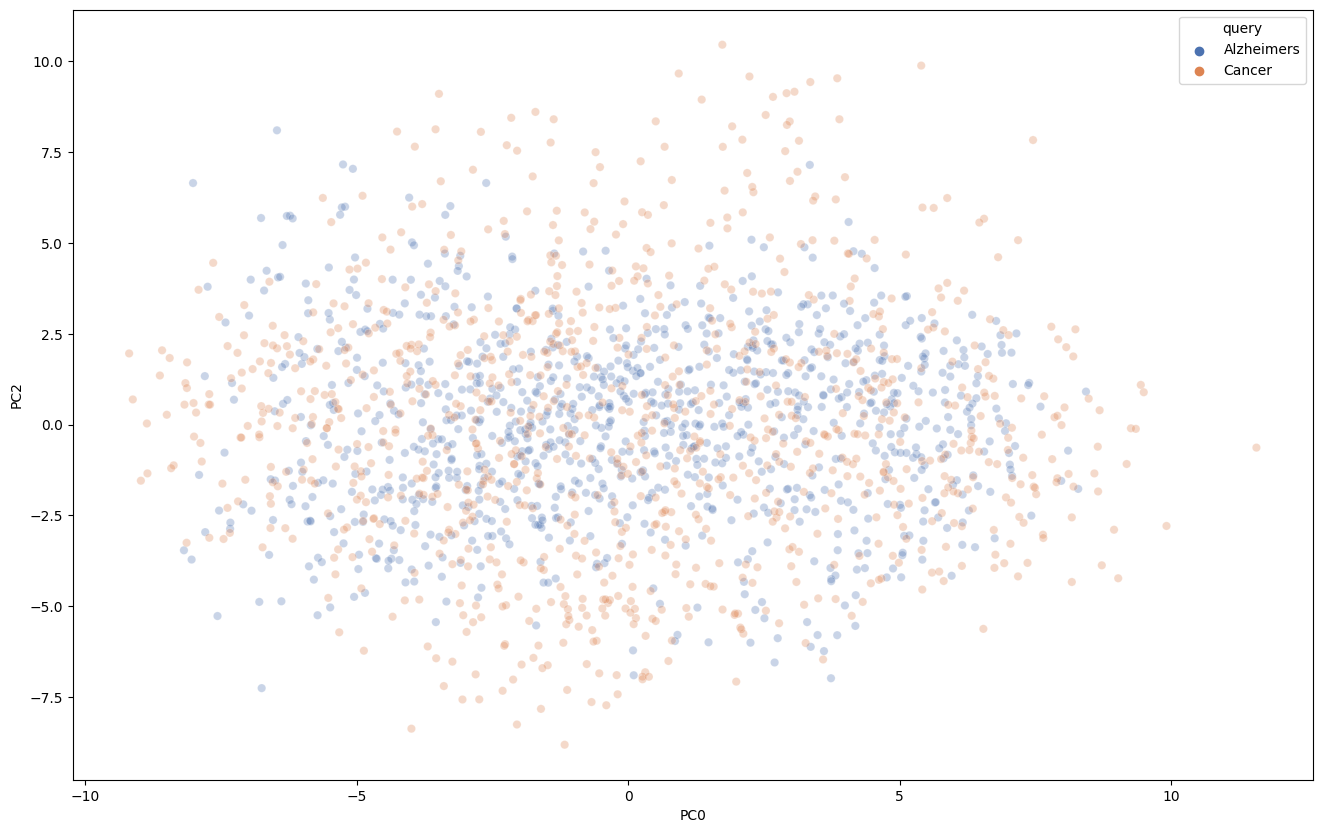

In [76]:
import seaborn as sns

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="PC0", y="PC2",
    hue="query",
    palette=sns.color_palette("deep", 2),
    data=result,
    legend="full",
    alpha=0.3
)